In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import numpy as np
from neurolib.models.jax.wc import WCModel
from neurolib.models.jax.wc.timeIntegration import timeIntegration_args, timeIntegration_elementwise
from neurolib.control.optimal_control.oc_jax import OcWc

import logging
import matplotlib.pyplot as plt

# Oscillating Target

In [3]:
def get_oscillating_input(duration=10.0, amplitude=1.0, period=2.5):
    # We import the model
    model = WCModel()
    dt = model.params["dt"]

    # We define a "zero-input", and a sine-input
    input = jnp.zeros((1, round(duration / dt)))
    input = input.at[0, :].set(
        amplitude * jnp.sin(2.0 * jnp.pi * jnp.arange(0, duration, dt) / period)
    )  # other functions or random values can be used as well
    zero_input = jnp.zeros_like(input)

    # We set the duration of the simulation and the initial values
    model.params["duration"] = duration
    x_init = 0.011225367461896877
    y_init = 0.013126741089502588
    model.params["exc_init"] = jnp.array([[x_init]])
    model.params["inh_init"] = jnp.array([[y_init]])

    # We set the stimulus in x and y variables, and run the simulation
    model.params["exc_ext"] = input
    model.params["inh_ext"] = zero_input
    model.run()

    # Define the result of the stimulation as target
    target = jnp.concatenate(
        (
            jnp.concatenate((model.params["exc_init"], model.params["inh_init"]), axis=1)[:, :, jnp.newaxis],
            jnp.stack((model.exc, model.inh), axis=1),
        ),
        axis=2,
    ).transpose((1, 0, 2))
    # Remove stimuli and re-run the simulation
    model.params["exc_ext"] = zero_input
    model.params["inh_ext"] = zero_input
    model.run()
    target_input = jnp.concatenate((input, zero_input), axis=0)[jnp.newaxis, :, :]

    return model, target, target_input

In [4]:
N_OPT_STEPS = 500

In [5]:
model, target, target_input = get_oscillating_input()

In [6]:
oc_wc = OcWc(
    model,
    target,
    optimizer=optax.adabelief(1e-1),
)

In [7]:
%%time
oc_wc.optimize_deterministic(N_OPT_STEPS, output_every_nth=50)

loss in iteration 0: 0.0004205371709193052
loss in iteration 50: 2.794790013785329e-06
loss in iteration 100: 3.791156853673619e-07
loss in iteration 150: 1.6397495453293177e-07
loss in iteration 200: 8.434575666592774e-08
loss in iteration 250: 4.857529598431241e-08
loss in iteration 300: 3.002576060714978e-08
loss in iteration 350: 1.948823221024184e-08
loss in iteration 400: 1.31478943331763e-08
loss in iteration 450: 9.155799461007793e-09
loss in iteration 500: 6.543116932976065e-09
Final loss : 6.543116932976065e-09
CPU times: user 6.52 s, sys: 845 ms, total: 7.36 s
Wall time: 4.87 s


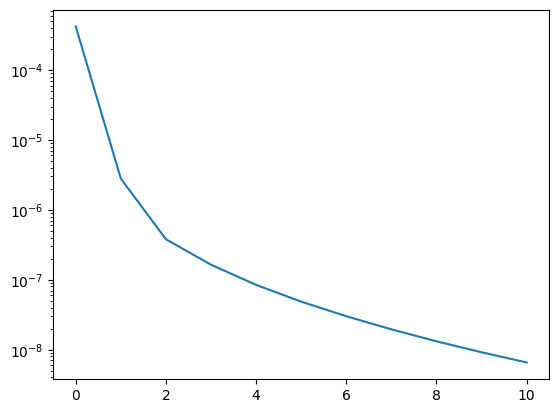

In [8]:
plt.plot(oc_wc.cost_history[:])
plt.yscale("log")

In [9]:
t, exc, inh, exc_ou, inh_ou = oc_wc.simulate(oc_wc.control).values()

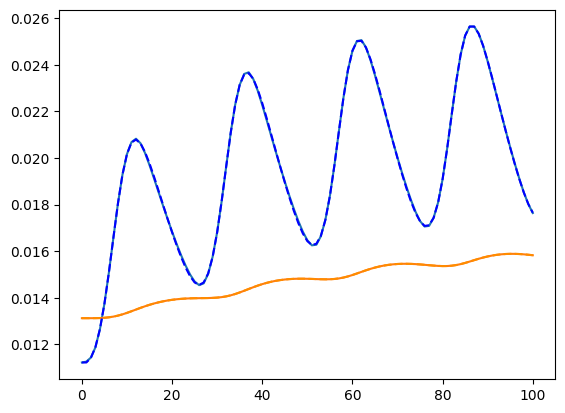

In [10]:
plt.plot(exc[0])
plt.plot(inh[0])
plt.plot(target[0, 0], linestyle="dashed", color="blue")
plt.plot(target[1, 0], linestyle="dashed", color="darkorange")

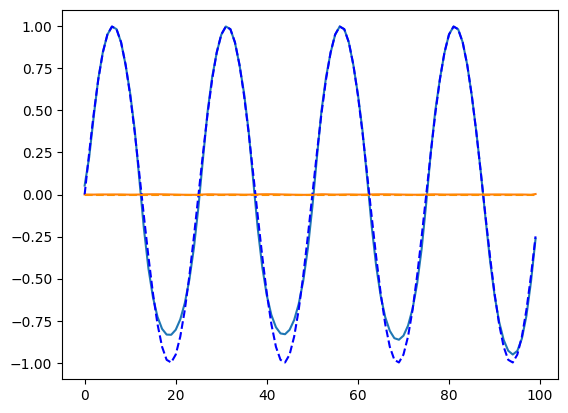

In [11]:
plt.plot(oc_wc.control["exc_ext"][0])
plt.plot(oc_wc.control["inh_ext"][0])
plt.plot(target_input[0, 0], linestyle="dashed", color="blue")
plt.plot(target_input[0, 1], linestyle="dashed", color="darkorange")

# Network Optimal Control

In [12]:
def get_network_model(duration=100.0, target="sync"):
    assert target in ("sync", "desync")
    if target == "sync":
        exc_ext_baseline = 1.6  # starts in desync
    elif target == "desync":
        exc_ext_baseline = 1.0  # starts in sync
    inh_ext_baseline = 0.4
    coupling = 0.8
    cmat = np.array(
        [
            [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
            [1.0, 0.0, 1.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
            [1.0, 1.0, 0.0, 1.0, 0.0, 1.0],
            [0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
        ]
    )
    dmat = np.array(
        [
            [0.0, 12.0, 0.0, 0.0, 0.0, 8.0],
            [8.0, 0.0, 13.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 9.0],
            [0.0, 0.0, 4.0, 0.0, 0.0, 11.0],
            [5.0, 17.0, 0.0, 14.0, 0.0, 18.0],
            [0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
        ]
    )

    model = WCModel(Cmat=cmat, Dmat=dmat)
    model.params["duration"] = duration
    model.params["K_gl"] = coupling
    model.params["exc_ext_baseline"] = exc_ext_baseline
    model.params["inh_ext_baseline"] = inh_ext_baseline
    if target == "sync":
        model.params["exc_init"] = jnp.array(
            [
                [
                    0.37629431,
                    0.3834639,
                    0.39003013,
                    0.39602553,
                    0.40148128,
                    0.40642708,
                    0.41089103,
                    0.41489965,
                    0.41847796,
                    0.4216496,
                ],
                [
                    0.07664943,
                    0.08165293,
                    0.08752262,
                    0.09441519,
                    0.1025122,
                    0.11201391,
                    0.12311931,
                    0.13598435,
                    0.1506553,
                    0.16699469,
                ],
                [
                    0.07875684,
                    0.07636045,
                    0.07407774,
                    0.07190517,
                    0.0698394,
                    0.06787725,
                    0.06601571,
                    0.06425192,
                    0.06258316,
                    0.06100687,
                ],
                [
                    0.44952161,
                    0.44716973,
                    0.44447951,
                    0.44142,
                    0.43795571,
                    0.43404647,
                    0.42964778,
                    0.42471168,
                    0.41918877,
                    0.41303149,
                ],
                [
                    0.21935044,
                    0.23761421,
                    0.25538914,
                    0.27241319,
                    0.28853971,
                    0.30370223,
                    0.31788527,
                    0.33110417,
                    0.34339215,
                    0.35479229,
                ],
                [
                    0.25446421,
                    0.24493458,
                    0.23571359,
                    0.22680549,
                    0.2182107,
                    0.20992683,
                    0.20194962,
                    0.19427347,
                    0.18689188,
                    0.17979782,
                ],
            ]
        )

        model.params["inh_init"] = jnp.array(
            [
                [
                    0.29211507,
                    0.30249908,
                    0.3124121,
                    0.32186336,
                    0.33086498,
                    0.33943103,
                    0.34757677,
                    0.35531816,
                    0.36267149,
                    0.36965306,
                ],
                [
                    0.10007338,
                    0.09902466,
                    0.09819244,
                    0.09762494,
                    0.09738978,
                    0.09758267,
                    0.0983393,
                    0.09984972,
                    0.10236971,
                    0.10621523,
                ],
                [
                    0.22296007,
                    0.21788133,
                    0.21291808,
                    0.20806914,
                    0.20333321,
                    0.19870887,
                    0.19419464,
                    0.18978898,
                    0.18549029,
                    0.18129693,
                ],
                [
                    0.45973146,
                    0.46165451,
                    0.46346183,
                    0.46515701,
                    0.46674288,
                    0.46822135,
                    0.46959324,
                    0.47085799,
                    0.47201328,
                    0.47305457,
                ],
                [
                    0.15372737,
                    0.16283135,
                    0.17347319,
                    0.18524034,
                    0.19771479,
                    0.21053877,
                    0.22343582,
                    0.23620594,
                    0.2487111,
                    0.26085994,
                ],
                [
                    0.44457159,
                    0.43947524,
                    0.43387474,
                    0.42783201,
                    0.42141133,
                    0.41467604,
                    0.40768612,
                    0.40049678,
                    0.39315779,
                    0.3857132,
                ],
            ]
        )

    model.run()

    return model

In [13]:
model = get_network_model()

In [14]:
N_OPT_STEPS = 500

In [15]:
oc_wc = OcWc(model, optimizer=optax.adabelief(5e-4))
oc_wc.weights["w_p"] = 0.0
oc_wc.weights["w_cc"] = 1.0
oc_wc.weights["w_2"] = 0.05
oc_wc.weights["w_1D"] = 0.05

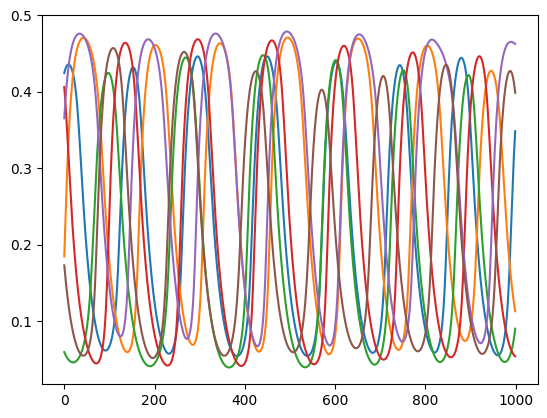

In [16]:
plt.plot(oc_wc.model.exc.T)

In [17]:
oc_wc.optimize_deterministic(N_OPT_STEPS, output_every_nth=10)

loss in iteration 0: 0.15419074998803042
loss in iteration 10: 0.05703944549241847
loss in iteration 20: -0.3097945930520037
loss in iteration 30: -0.37562986998246883
loss in iteration 40: -0.47208481578432426
loss in iteration 50: -0.519499567669051
loss in iteration 60: -0.5564611060601763
loss in iteration 70: -0.5909950672965953
loss in iteration 80: -0.6234688957979501
loss in iteration 90: -0.6562222002586331
loss in iteration 100: -0.6896399929303546
loss in iteration 110: -0.7236691271373746
loss in iteration 120: -0.756900050083435
loss in iteration 130: -0.7872616077328858
loss in iteration 140: -0.81418746430439
loss in iteration 150: -0.8380713719026578
loss in iteration 160: -0.8595732233362361
loss in iteration 170: -0.8794598556790216
loss in iteration 180: -0.8986005435285532
loss in iteration 190: -0.9184614710759836
loss in iteration 200: -0.9432712788774769
loss in iteration 210: -0.9845008437679779
loss in iteration 220: -1.007528295600197
loss in iteration 230: -1

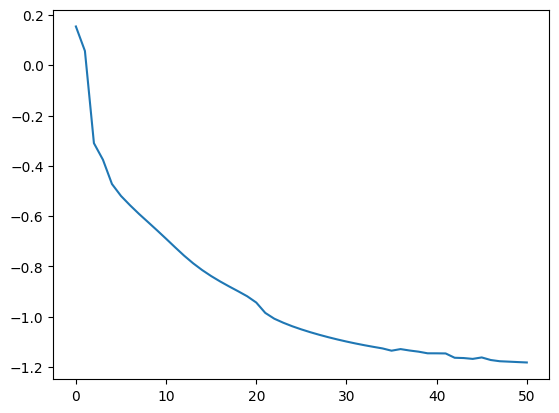

In [18]:
plt.plot(oc_wc.cost_history)

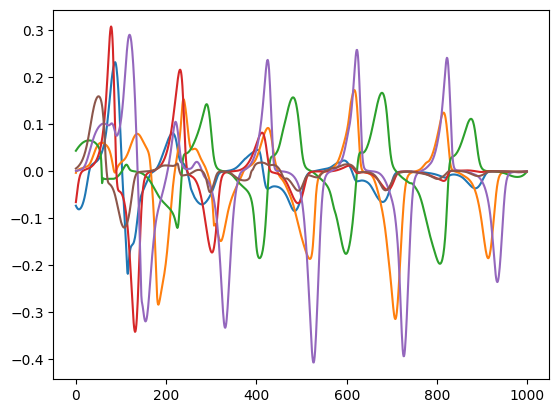

In [19]:
plt.plot(oc_wc.control["exc_ext"].T)

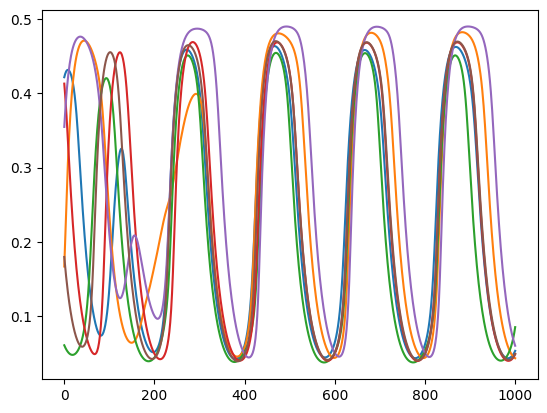

In [20]:
output = oc_wc.get_output(oc_wc.control)
plt.plot(output[0].T)

### Desync Task

In [21]:
model = get_network_model(target="desync")

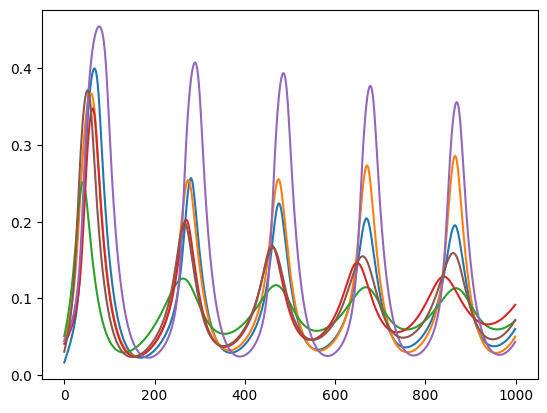

In [22]:
plt.plot(model.exc.T)

In [23]:
oc_wc = OcWc(model, optimizer=optax.adabelief(1e-3))
oc_wc.weights["w_p"] = 0.0
oc_wc.weights["w_cc"] = -1.0
oc_wc.weights["w_2"] = 0.05
oc_wc.weights["w_1D"] = 0.05

In [24]:
oc_wc.optimize_deterministic(N_OPT_STEPS, output_every_nth=10)

loss in iteration 0: 1.6174810682412006
loss in iteration 10: 1.2153733298354865
loss in iteration 20: 0.7901938573733853
loss in iteration 30: 0.48882484376013496
loss in iteration 40: 0.31016718425833556
loss in iteration 50: 0.22139702984328818
loss in iteration 60: 0.16709540537804074
loss in iteration 70: 0.12515011153757993
loss in iteration 80: 0.0911187575809258
loss in iteration 90: 0.06262166417570547
loss in iteration 100: 0.040105869361924396
loss in iteration 110: 0.02347360319017483
loss in iteration 120: 0.010844900203739738
loss in iteration 130: 0.0009439209548847693
loss in iteration 140: -0.007062937045964723
loss in iteration 150: -0.0137333330811103
loss in iteration 160: -0.019444427928181685
loss in iteration 170: -0.02443481403500075
loss in iteration 180: -0.028810741620006797
loss in iteration 190: -0.032627843160631276
loss in iteration 200: -0.03596223119934511
loss in iteration 210: -0.03890604118148788
loss in iteration 220: -0.04154893494933609
loss in it

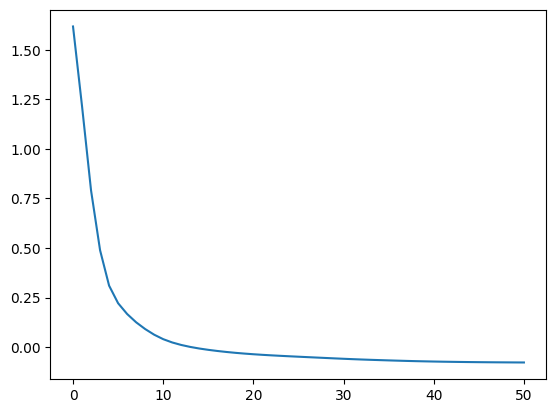

In [25]:
plt.plot(oc_wc.cost_history)

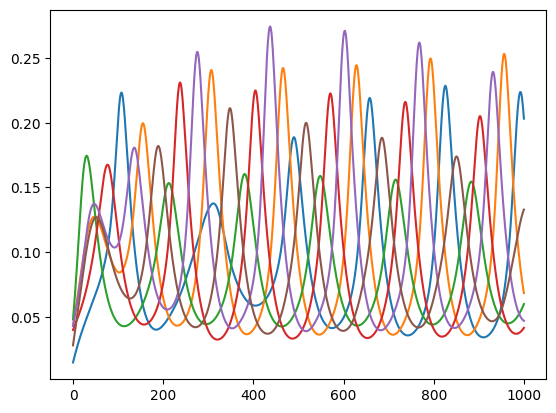

In [26]:
output = oc_wc.get_output(oc_wc.control)
plt.plot(output[0].T)

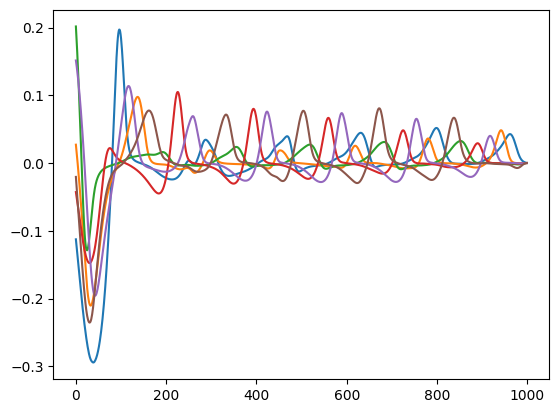

In [29]:
plt.plot(oc_wc.control["exc_ext"].T)